## Testing for data scrabing on Esco and Jobnet

In [231]:
# Import magics

# !pip install selenium
# !pip install webdriver_manager
# !python -m nltk.downloader popular
# !pip install tensorflow
# !pip install spacy
# !pip install wordloud
# !python -m spacy download da_core_news_md
# !pip install keras

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pathlib import Path
import re
import requests
from selenium import webdriver
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
from io import StringIO
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
import spacy
from spacy import displacy
from tensorflow.keras import layers
from spacy.lang.da.stop_words import STOP_WORDS

import string
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from function import *

In [232]:
stopwords = set(STOPWORDS)

stop_word = nltk.corpus.stopwords.words('danish') + ['hr','bringe','ppr','vores','ønsker','nye','hverdag','del','inden','søger', 
'kan','egedal','oktober','kompetencer','li','ul','text','align','justify','br','p','div','strong',
'style','href','både','ung','halsnæs','egen','daglig','hel','vigtig','relevant','velkommen','tidlig','første','enkelt','tæt','flest',
'høj','ny','fast','mulig','lille','øvrig','mange','meget','central','voksen','stor','gammel','konkret','aktuel','ugenligt','gavn','formår',
'god','vant','int','fig','centralt','evalueres','mittag','løbende','spise','nær','nemmere']

nlp = spacy.load('da_core_news_md')

# Jobindex

## Selecting data on Jobindex

In [233]:
from queue import Empty

def extract_jobindex(tag, pages):
    flat_list = []
    url_list = []
    total_pages = range(pages)
    headers = {'User-Agent':'kjp538@alumni.ku.dk'}


    for page in total_pages:
        url = f"https://www.jobindex.dk/jobsoegning?maxdate=20220101&mindate=20210101&page={page}&jobage=archive&q={tag}"
                        
        r = requests.get(url, headers)
            
        soup = BeautifulSoup(r.content.decode("utf-8"), "html.parser")
                        
        divs = soup.find_all("div", class_="jobsearch-result")
        
        for item in divs:
            try:
                job_url = item.select_one('[data-click*="u="]:has(> b)')['data-click']
                url_list.append(job_url)
            except:
                pass

        for i in url_list:
            link = 'http://www.jobindex.dk' + i
            flat_list.append(link)

    return flat_list

### Cleaning Jobindex data

In [234]:
porter = nltk.PorterStemmer()
# nltk.download('omw-1.4')
wnl = nltk.WordNetLemmatizer()

In [235]:
def clean_jobindex(search_word):
    final_job = []
    jobindex = []
    info_job = [] 
    flat_list = []
    final_list = []

    headers = {'User-Agent':'kjp538@alumni.ku.dk'}
    job = extract_jobindex(search_word, 4)
    
    for i in job:
        url = f"{i}"
        r = requests.get(url, headers)
        soup = BeautifulSoup(r.content.decode("utf-8"), "html.parser")
        iframe = soup.find_all('iframe', class_='archive-content')
        for i in iframe:
            link = i['src']
            info_job.append(link)

    for item in info_job:
        links = 'http://www.jobindexarkiv.dk/cgi/showarchive.cgi' + item
        jobindex.append(links)


    for i in jobindex:
        url_ = f"{i}"
        r = requests.get(url_, headers)
        soup = BeautifulSoup(r.content, "html.parser")
        content = soup.find_all('body')
        for i in content:
            text = i.get_text()
            flat_list.append(text)

    job_ = ' '.join(str(i) for i in flat_list)
    _job = nltk.word_tokenize(clean_text(job_))
    for word in _job:
        if word not in stop_word:
            final_job.append(word)
            
    return final_job

jobindex_psych = [wnl.lemmatize(i) for i in clean_jobindex('cand.psych')]
jobindex_oecon = [wnl.lemmatize(i) for i in clean_jobindex('cand.oecon')]
jobindex_pol = [wnl.lemmatize(i) for i in clean_jobindex('cand.scient.pol')]
jobindex_anth = [wnl.lemmatize(i) for i in clean_jobindex('cand.scient.anth')]
jobindex_soc = [wnl.lemmatize(i) for i in clean_jobindex('cand.scient.soc')]

jobindex_psych_full = ' '.join(jobindex_psych)
jobindex_oecon_full = ' '.join(jobindex_oecon)
jobindex_pol_full = ' '.join(jobindex_pol)
jobindex_anth_full = ' '.join(jobindex_anth)
jobindex_soc_full = ' '.join(jobindex_soc)

print(f'Number of word in \n psych: {len(jobindex_psych_full)}, \n oecon: {len(jobindex_oecon_full)}, \n pol: {len(jobindex_pol_full)}, \n anth: {len(jobindex_anth_full)}, \n soc: {len(jobindex_soc_full)}')

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


Number of word in 
 psych: 549691, 
 oecon: 836607, 
 pol: 823483, 
 anth: 163946, 
 soc: 409941


### Plotting Jobindex data using Wordcloud

In [236]:
write_text('cand.oecon', jobindex_oecon)
write_text('cand.psych', jobindex_psych)
write_text('cand.pol', jobindex_pol)
write_text('cand.anth', jobindex_anth)
write_text('cand.soc', jobindex_soc)

def stacy_words(input):
    document = nlp(open(f'{input}', encoding="utf-8").read())
    adjs = []
    for token in document:
       if token.pos_ == 'ADJ':
        adjs.append(token.lemma_)
    # adjs_tally = Counter(adjs)
    # adjs_tally.most_common()
        adj = ' '.join(adjs)
    return adj

path = Path('/Users/nicolaibernsen/Desktop/KU/9.Semester/Introduction_to_Social_Datascience/ISDS/Exam/')

oecon_adjs = stacy_words(path / 'cand.oecon.txt')
psych_adjs = stacy_words(path / 'cand.psych.txt')
pol_adjs = stacy_words(path / 'cand.pol.txt')
anth_adjs = stacy_words(path / 'cand.anth.txt')
soc_adjs = stacy_words(path / 'cand.soc.txt')

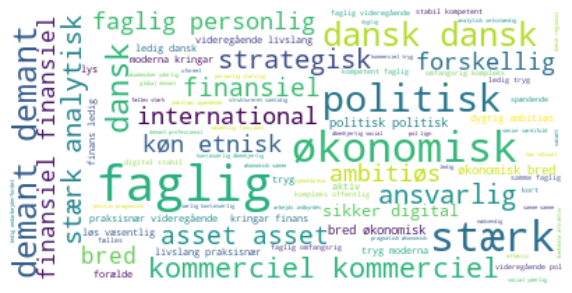

In [237]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(oecon_adjs)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

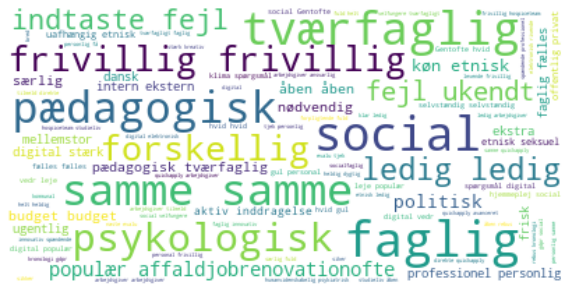

In [238]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(psych_adjs)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

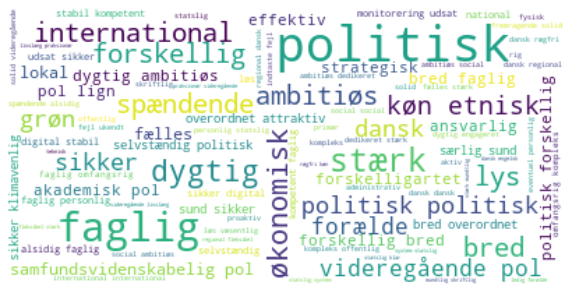

In [239]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(pol_adjs)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

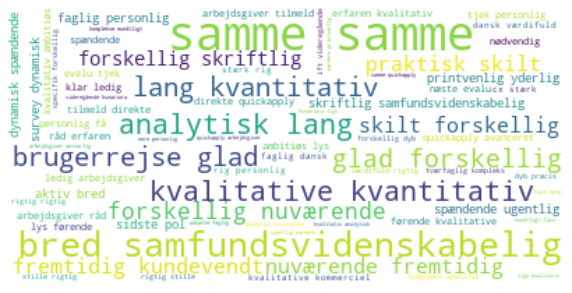

In [240]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(anth_adjs)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

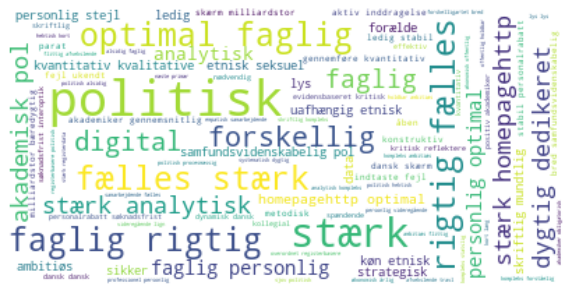

In [241]:
wordcloud = WordCloud(stopwords=stop_word, max_font_size=35, max_words=100, background_color='white').generate(soc_adjs)
fig = plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Importing skills from ESCO

In [242]:
occupations = ['http://data.europa.eu/esco/occupation/99492920-e5a5-4dba-9e5a-93193147198c', 
'http://data.europa.eu/esco/occupation/11df8941-508c-4103-ad40-52cdf9430a59', 
'http://data.europa.eu/esco/occupation/acf69cab-8629-45c8-ae10-c8fb15f474b6', 
'http://data.europa.eu/esco/occupation/52ded7d7-11df-42e3-b90a-d7f4b70fb4b9',
'http://data.europa.eu/esco/occupation/4f89b0d2-b666-4890-af01-25d1d60da1f3']

jobs = pd.DataFrame(columns=['job_title', 'essential_skill', 'optional_skill'])

for i in occupations:
    jobs = jobs.append(fetching_occupation(i))

jobs = jobs.apply(lambda x: x.replace({'økonom':'cand.oecon', 'psykolog':'cand.psych', 'antropolog':'cand.scient.anth', 
'politolog':'cand.scient.pol', 'sociolog':'cand.scient.soc'}, regex=True))
jobs

,job_title,essential_skill,optional_skill
0,cand.oecon,matematik,finansielle markeder
1,cand.oecon,levere rapporter med cost-benefit-analyser,offentlig ret
2,cand.oecon,udføre analytiske matematiske beregninger,salgsfremmende teknikker
3,cand.oecon,anvende videnskabelige metoder,markedsanalyse
4,cand.oecon,principper for virksomhedsledelse,udvikle videnskabelige teorier
...,...,...,...
6,cand.scient.pol,politik,udenrigsanliggender
7,cand.scient.pol,regeringspolitik,vurdere risikofaktorer
8,cand.scient.pol,politiske ideologier,rådgive om PR
9,cand.scient.pol,anvende videnskabelige metoder,gennemføre kvalitativ forskning


In [243]:
def find_search_words(df, type_):
    search_words = []
    searchword = df.loc[jobs['job_title'] == f'{type_}']
    for value in searchword['optional_skill']:
        search_words.append(value)
    for value in searchword['essential_skill']:
        search_words.append(value)
    return search_words

esco_oecon = find_search_words(jobs, 'cand.oecon')
esco_psych = find_search_words(jobs, 'cand.psych')
esco_pol = find_search_words(jobs, 'cand.scient.pol')
esco_anth = find_search_words(jobs, 'cand.scient.anth')
esco_soc = find_search_words(jobs, 'cand.scient.soc')

print(f'Number of skills in: \n psych: {len(esco_psych)}, \n oecon: {len(esco_oecon)}, \
    \n pol: {len(esco_pol)}, \n anth: {len(esco_anth)}, \n soc: {len(esco_soc)}')

Number of skills in: 
 psych: 38, 
 oecon: 30,     
 pol: 22, 
 anth: 20, 
 soc: 28


## Scraping UG

In [244]:
search_list = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

education_url = []

for k in search_list:
    for i in range(1):
        try: 
            education_url.append(UG(i,k))
        except:
            break
        
education_url[1].pop(0)
del education_url[4][0:3]

In [245]:
# psych = nltk.word_tokenize(extract_UG(education_url[0][0]))
# oecon = nltk.word_tokenize(extract_UG(education_url[1][0]))
# pol = nltk.word_tokenize(extract_UG(education_url[2][0]))
# anth = nltk.word_tokenize(extract_UG(education_url[3][0]))
# soc = nltk.word_tokenize(extract_UG(education_url[4][0]))
# psych_final = []
# for word in psych:
#     if word not in stop_word:
#         psych_final.append(word)

In [246]:
ku_list = []

search_list = ['psykologi', 'sociologi', 'statskundskab', 'antropologi', 'oekonomi']

for k in search_list:
    soup = extract_ku(k)
    ku_list.append(transform_ku(soup))

ku_df = pd.DataFrame(data=ku_list)

#Merging the two colums 
ku_df=ku_df[0]+ku_df[1]

#Making the object a dataframe
ku_df=pd.DataFrame(ku_df)

ku_df=pd.DataFrame.transpose(ku_df)

ku_df.columns=['cand.psych_ku', 'cand.scient.soc_ku', 'cand.scient.pol_ku', 'cand.scient.anth_ku', 'cand.oecon_ku']
soup = extract_au('statskundskab')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_stats = text[75:77]

stats_df = pd.DataFrame(data=text_stats, columns=['cand.scient.pol_au'])
stats = pd.DataFrame([', '.join(stats_df['cand.scient.pol_au'].to_list())], columns=['cand.scient.pol_au'])
soup = extract_au('oekonomi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_oek = text[60:62]

oek_df = pd.DataFrame(data=text_oek, columns=['cand.oecon_au'])
oek = pd.DataFrame([', '.join(oek_df['cand.oecon_au'].to_list())], columns=['cand.oecon_au'])
soup = extract_au('antropologi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_ant = text[50:55]

ant_df = pd.DataFrame(data=text_ant, columns=['cand.scient.anth_au'])
ant = pd.DataFrame([', '.join(ant_df['cand.scient.anth_au'].to_list())], columns=['cand.scient.anth_au'])
soup = extract_au('psykologi')

divs = soup.find_all("div", class_="large-8 medium-8 medium-only-portrait-12 small-12 columns")

text = soup.find_all('p')

text_psyk = text[74:78]

psyk_df = pd.DataFrame(data=text_psyk, columns=['cand.psych_au'])
psyk = pd.DataFrame([', '.join(psyk_df['cand.psych_au'].to_list())], columns=['cand.psych_au'])
frames = [ant, stats, psyk, oek]

au_df = pd.concat(frames, axis=1)

au_df_list = au_df['cand.scient.anth_au'].to_list()
au_list = []

for i in au_df_list:
    au_list.append(clean_text(i))

au_list
def transform_aau(soup):

    divs = soup.find_all("main", class_="Main_Main__2KIvG")

    for item in divs:
        text_aau = item.find_all()[0].text.strip()

        aau_text = {
            "text_aau" : text_aau, 
        }
        aau_list.append(aau_text)

        text_aau = clean_text(text_aau)
        
    return text_aau

aau_list = []

search_list = ['psykologi', 'sociologi', 'oekonomi']

for k in search_list:
    try: 
        soup = extract_aau(k)
        transform_aau(soup)
    except:
        break

aau_df = pd.DataFrame(data=aau_list)

aau_df=pd.DataFrame.transpose(aau_df)

aau_df.columns=['cand.psych_aau', 'cand.scient.soc_aau', 'cand.oecon_aau']

aau_df = aau_df.reset_index(drop=True)

aau_df

## Combining Dataframes
merge_frames = [ku_df, au_df, aau_df]

combined_df = pd.concat(merge_frames, axis=1)

combined_df['cand.psych_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.psych_ku']]
combined_df['cand.scient.pol_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.pol_ku']]
combined_df['cand.oecon_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.oecon_ku']]
combined_df['cand.scient.anth_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.anth_ku']]
combined_df['cand.scient.soc_ku_string'] = [','.join(map(str, l)) for l in combined_df['cand.scient.soc_ku']]

combined_df['cand.psych'] = combined_df['cand.psych_aau'] + combined_df['cand.psych_au'] + combined_df['cand.psych_ku_string']
combined_df['cand.scient.anth'] = combined_df['cand.scient.anth_au'] + combined_df['cand.scient.anth_ku_string']
combined_df['cand.scient.pol'] = combined_df['cand.scient.pol_au'] + combined_df['cand.scient.pol_ku_string']
combined_df['cand.scient.soc'] = combined_df['cand.scient.soc_aau'] + combined_df['cand.scient.soc_ku_string']
combined_df['cand.oecon'] = combined_df['cand.oecon_aau'] + combined_df['cand.oecon_au'] + combined_df['cand.oecon_ku_string']
combined_df.drop(['cand.psych_aau', 'cand.scient.soc_aau', 'cand.oecon_aau', 'cand.psych_au', \
                  'cand.scient.anth_au', 'cand.scient.pol_au','cand.oecon_au', \
                  'cand.psych_ku', 'cand.scient.soc_ku', 'cand.scient.pol_ku', 'cand.scient.anth_ku', \
                  'cand.oecon_ku', 'cand.psych_ku_string', 'cand.scient.pol_ku_string', 'cand.oecon_ku_string', \
                  'cand.scient.anth_ku_string', 'cand.scient.soc_ku_string'], axis=1, inplace=True)
university_df = combined_df
university_df

## Scraping UG
search_list = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

education_url = []

for k in search_list:
    for i in range(1):
        try: 
            education_url.append(UG(i,k))
        except:
            break
        
education_url[1].pop(0)
del education_url[4][0:3]
psych = clean_text(extract_UG(education_url[0][0]))
oecon = extract_UG(education_url[1][0])
pol = extract_UG(education_url[2][0])
anth = extract_UG(education_url[3][0])
soc = extract_UG(education_url[4][0])

## Combining skills from UG and Universities
strings_psych = psych + university_df['cand.psych']
strings_oecon = oecon + university_df['cand.oecon']
strings_pol = pol + university_df['cand.scient.pol']
strings_anth = anth + university_df['cand.scient.anth']
strings_soc = soc + university_df['cand.scient.soc']


psych_comb = " ".join(strings_psych)
oecon_comb = " ".join(strings_oecon)
pol_comb = " ".join(strings_pol)
anth_comb = " ".join(strings_anth)
soc_comb = " ".join(strings_soc)
psych_series = pd.Series(psych_comb)
oecon_series = pd.Series(oecon_comb)
pol_series = pd.Series(pol_comb)
anth_series = pd.Series(anth_comb)
soc_series = pd.Series(soc_comb)

psych_df = pd.DataFrame(psych_series)
oecon_df = pd.DataFrame(oecon_series)
pol_df = pd.DataFrame(pol_series)
anth_df = pd.DataFrame(anth_series)
soc_df = pd.DataFrame(soc_series)

psych_df['cand.psych'] = psych_df[0]
oecon_df['cand.oecon'] = oecon_df[0]
pol_df['cand.scient.pol'] = pol_df[0]
anth_df['cand.scient.anth'] = anth_df[0]
soc_df['cand.scient.soc'] = soc_df[0]
final_df = pd.concat([psych_df['cand.psych'], oecon_df['cand.oecon'], pol_df['cand.scient.pol'], \
                      anth_df['cand.scient.anth'], soc_df['cand.scient.soc']], axis=1)

final_df = make_a_list(final_df['cand.psych']).append(make_a_list(final_df['cand.oecon'])).append(make_a_list(final_df['cand.scient.pol']))\
    .append(make_a_list(final_df['cand.scient.anth'])).append(make_a_list(final_df['cand.scient.soc']))

final_df = final_df.T
final_df.columns = ['cand.psych', 'cand.oecon', 'cand.scient.pol', 'cand.scient.anth', 'cand.scient.soc']

final_df['cand.psych'] = final_df['cand.psych'].apply(nltk.word_tokenize)
final_df['cand.oecon'] = final_df['cand.oecon'].apply(nltk.word_tokenize)
final_df['cand.scient.pol'] = final_df['cand.scient.pol'].apply(nltk.word_tokenize)
final_df['cand.scient.anth'] = final_df['cand.scient.anth'].apply(nltk.word_tokenize)
final_df['cand.scient.soc'] = final_df['cand.scient.soc'].apply(nltk.word_tokenize)

final_df['cand.psych'] = final_df['cand.psych'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.oecon'] = final_df['cand.oecon'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.scient.pol'] = final_df['cand.scient.pol'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.scient.anth'] = final_df['cand.scient.anth'].apply(lambda words: [word for word in words if word not in stop_word])
final_df['cand.scient.soc'] = final_df['cand.scient.soc'].apply(lambda words: [word for word in words if word not in stop_word])

In [247]:
def df_to_list(series):
    final_list_ = []
    for i in series:
        list_ = list(i)
    list_ = ' '.join(list_)
    final_list = list_.split(' ')
    for word in final_list:
        if word not in stop_word:
            final_list_.append(word)
    return final_list_

udd_oecon_list = df_to_list(final_df['cand.oecon'])
udd_psych_list = df_to_list(final_df['cand.psych'])
udd_pol_list = df_to_list(final_df['cand.scient.pol'])
udd_anth_list = df_to_list(final_df['cand.scient.anth'])
udd_soc_list = df_to_list(final_df['cand.scient.soc'])

In [248]:
psych_text = tf.data.TextLineDataset('/Users/nicolaibernsen/Desktop/KU/9.Semester/Introduction_to_Social_Datascience/ISDS_edit/Exam/psych.txt')\
  .filter(lambda x: tf.cast(tf.strings.length(x), bool))

def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  return tf.strings.regex_replace(lowercase,
                                  '[%s]' % re.escape(string.punctuation), '')


# Define the vocabulary size and the number of words in a sequence.
vocab_size = 4096
sequence_length = 10

# Use the `TextVectorization` layer to normalize, split, and map strings to
# integers. Set the `output_sequence_length` length to pad all samples to the
# same length.
vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

vectorize_layer.adapt(psych_text.batch(4096))
inverse_vocab = vectorize_layer.get_vocabulary()
print(inverse_vocab[:20])

['', '[UNK]', 'lærer', 'kan', 'psykologer', 'arbejde', 'undervisning', 'uddannelsen', 'social', 'på', 'psykologi', 'private', 'kandidatuddannelsen', 'inden', 'forskellige', 'du', 'candpsych', 'arbejder', 'ansat', 'øver']


In [249]:
SEED = 42
AUTOTUNE = tf.data.AUTOTUNE
text_vector_ds = psych_text.batch(1024).prefetch(AUTOTUNE).map(vectorize_layer).unbatch()
sequences = list(text_vector_ds.as_numpy_iterator())
print(len(sequences))

1


In [250]:
for seq in sequences[:10]:
  print(f"{seq} => {[inverse_vocab[i] for i in seq]}")

[ 9 12 17 22 85 19 95  2 51  7] => ['på', 'kandidatuddannelsen', 'arbejder', 'videnskabeligt', 'faget', 'øver', 'bruge', 'lærer', 'praksis', 'uddannelsen']


### Vectorizing words with TfidfVectorizer

In [251]:
esco_1_oecon = []
for item in esco_oecon:
    if len(item.split(' ')) == 1:
        esco_1_oecon.append(item)
esco_1_oecon

['markedsanalyse',
 'projektstyring',
 'regnskabsanalyse',
 'indholdsmarkedsføringsstrategi',
 'regnskabsteknikker',
 'matematik',
 'statistik',
 'skattelovgivning',
 'cand.oeconi']

In [252]:
def find_words(words_to_search, list_, name):
    for i in words_to_search:
        if i in list_:
            print(f'{i} is present in the list of {name}')

find_words(esco_oecon, jobindex_oecon, 'oecon')
find_words(esco_anth, jobindex_anth, 'anth')
find_words(esco_pol, jobindex_pol, 'pol')
find_words(esco_psych, jobindex_psych, 'psych')
find_words(esco_soc, jobindex_soc, 'soc')

projektstyring is present in the list of oecon
regnskabsanalyse is present in the list of oecon
statistik is present in the list of oecon
samfundsvidenskab is present in the list of pol
politik is present in the list of pol
statistik is present in the list of pol
psykiatri is present in the list of psych
samfundsvidenskab is present in the list of soc
historie is present in the list of soc
statistik is present in the list of soc


In [230]:
for i in esco_oecon:
    re.findall(i, jobindex_oecon_full)

NameError: name 'jobindex_oecon_full' is not defined

In [ ]:
def make_vectoizer(input_udd, input_jobindex):
    vector = TfidfVectorizer(lowercase=False)
    ret = vector.fit_transform([input_jobindex, input_udd])
    return 

countvector = CountVectorizer(lowercase=False)
tfidfvetor = TfidfVectorizer(lowercase=False)

In [ ]:
terms = countvector.fit_transform(esco_1_oecon)

terms_vector = countvector.transform(jobindex_oecon)

df_1 = pd.DataFrame(terms_vector.todense())

df_1.to_csv('out.csv')

# tfidfvectorizer_oecon.fit_transform(jobindex_oecon, )

# feature_names = tfidfvectorizer_oecon.get_feature_names()

# dense = vector.todense()

# denselist = dense.tolist()

# df = pd.DataFrame(denselist, columns=feature_names)

# summarize
# print(tfidfvectorizer.idf_)
# print(vector_jobindex.idf_)

# lr_regression = LogisticRegression(random_state=0) #Text classifier

# lr_regression.fit(vector_jobindex, jobindex_oecon)

# preds = lr_regression.predict(vector_jobindex)

# lr_regression.fit(vector_jobindex, vector_udd)


### Vectorizing words with Bert

In [191]:
for item in df_1.items():
    if item == 1:
        print(item)

In [255]:
# !pip install sentence_transformers
from sentence_transformers import SentenceTransformer

sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

def bert_model_simmilarities(udd_list, jobindex_list):
    list_ = []
    document_embeddings = sbert_model.encode([udd_list, jobindex_list])
    similarities = cosine_similarity(document_embeddings)
    for cell in np.nditer(similarities):
        if cell < 0.9 and cell > 0.1:
            list_.append(cell)

    return list_[1].tolist()

def bert_model_differences(udd_list, jobindex_list):
    list_ = []
    document_embeddings = sbert_model.encode([udd_list, jobindex_list])
    differences = euclidean_distances(document_embeddings)

    for cell in np.nditer(differences):
        if cell > 0.1:
            list_.append(cell)

    return list_[1].tolist()

arr_oecon = bert_model_differences(udd_oecon_list, jobindex_oecon)
arr_oecon_2 = bert_model_simmilarities(udd_oecon_list, jobindex_oecon)

arr_psych = bert_model_differences(udd_psych_list, jobindex_psych)
arr_psych_2 = bert_model_simmilarities(udd_psych_list, jobindex_psych)

arr_pol = bert_model_differences(udd_pol_list, jobindex_pol)
arr_pol_2 = bert_model_simmilarities(udd_pol_list, jobindex_pol)

arr_soc = bert_model_differences(udd_soc_list, jobindex_soc)
arr_soc_2 = bert_model_simmilarities(udd_soc_list, jobindex_soc)

arr_anth = bert_model_differences(udd_anth_list, jobindex_anth)
arr_anth_2 = bert_model_simmilarities(udd_anth_list, jobindex_anth)

list_ = (arr_oecon, arr_psych, arr_pol, arr_soc, arr_anth)
_list = (arr_oecon_2, arr_psych_2, arr_pol_2, arr_soc_2, arr_anth_2)

df_diff = pd.DataFrame(list_)

df_sim = pd.DataFrame(_list)

df = pd.concat([df_diff, df_sim], axis=1)
df = df.rename(index={0:'cand.oecon', 1:'cand.psych', 2:'cand.scient.pol', 3:'cand.scient.soc', 4:'cand.scient.anth'})
df.columns=['Euclidean Distance', 'Cosine Similarity']

In [256]:
df

,Euclidean Distance,Cosine Similarity
cand.oecon,7.177022,0.834945
cand.psych,9.202934,0.753982
cand.scient.pol,10.891268,0.694526
cand.scient.soc,10.424495,0.732556
cand.scient.anth,8.852099,0.781766
